#108 - PLP

##Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
import numpy as np
import networkx as nx
from nltk.corpus import stopwords
import nltk
import re
import unicodedata

##PLP - 108 - Novo DataFrame

###Importação

In [82]:
new_df = pd.read_excel(r'/content/PLP - 108.xlsx')

In [83]:
new_df

,Emenda,Conteudo
0,EMENDA_100_-_PLP_108_2024,Dê-se nova redação ao inciso IV do § 3º do art...
1,EMENDA_101_-_PLP_108_2024,Dê-se ao inciso V do caput do art. 59 do Proje...
2,EMENDA_102_-_PLP_108_2024,Dê-se nova redação ao § 1º do art. 112; e acre...
3,EMENDA_103_-_PLP_108_2024,"Acrescente-se, onde couber, no Projeto o segui..."
4,EMENDA_104_-_PLP_108_2024,Altere-se o PLP 108/2024 para acrescentar ao a...
...,...,...
306,EMENDA_96_-_PLP_108_2024,"Acrescente-se ao art. 194 do PLP 108/2024, que..."
307,EMENDA_97_-_PLP_108_2024,Dê-se nova redação ao inciso I do §2º do art. ...
308,EMENDA_98_-_PLP_108_2024,Dê-se nova redação aos §§ 1º e 3º do art. 92 d...
309,EMENDA_99_-_PLP_108_2024,"Acrescente-se, onde couber, no Projeto o segui..."


In [84]:
new_df.columns

Index(['Emenda', 'Conteudo'], dtype='object')

###Limpeza

In [85]:
def limpa_emenda(df):
    df["Emenda"] = df["Emenda"].str.extract(r"(EMENDA[\s_\-]*\d+)", expand=False).str.replace(r"[\s_\-]+", " ", regex=True).str.strip().str.upper()
    return df

In [86]:
limpa_emenda(new_df)

,Emenda,Conteudo
0,EMENDA 100,Dê-se nova redação ao inciso IV do § 3º do art...
1,EMENDA 101,Dê-se ao inciso V do caput do art. 59 do Proje...
2,EMENDA 102,Dê-se nova redação ao § 1º do art. 112; e acre...
3,EMENDA 103,"Acrescente-se, onde couber, no Projeto o segui..."
4,EMENDA 104,Altere-se o PLP 108/2024 para acrescentar ao a...
...,...,...
306,EMENDA 96,"Acrescente-se ao art. 194 do PLP 108/2024, que..."
307,EMENDA 97,Dê-se nova redação ao inciso I do §2º do art. ...
308,EMENDA 98,Dê-se nova redação aos §§ 1º e 3º do art. 92 d...
309,EMENDA 99,"Acrescente-se, onde couber, no Projeto o segui..."


In [87]:
new_df.loc[0, 'Conteudo']

'Dê-se nova redação ao inciso IV do § 3º do art. 8º, aos §§ 4º e 5º do art.\n8º, ao inciso II do caput do art. 9º e ao inciso I do § 2º do art. 9º; suprimam-se os §§\n6º a 9º do art. 8º e o inciso II do § 2º do art. 9º; e acrescente-se art. 11-1 à Seção II do\nCapítulo III do Título I do Livro I do Projeto, nos termos a seguir:\n“Art. 8º ............................................................................................................\n..........................................................................................................................\n§ 3º ...................................................................................................................\n..........................................................................................................................\nIV – será realizada por meio de um único processo eleitoral,\norganizado pela Confederação Nacional de Municípios (CNM) e pela Frente\nNacional de Prefeitas e Prefeitos (FNP), por 

###Separa Conteudo em dois

In [88]:
def separar_aspas(texto):
    if pd.isna(texto):
        return pd.Series([None, None])

    texto_str = str(texto).strip()

    # Se tiver aspas curvas
    if '“' in texto_str and '”' in texto_str:
        # Extrai conteúdo entre aspas
        match = re.search(r'“([^”]+)”', texto_str)
        if match:
            conteudo_aspas = match.group(1).strip()

            # Normaliza para facilitar análise
            conteudo_normalizado = unicodedata.normalize('NFKD', conteudo_aspas).encode('ASCII', 'ignore').decode('utf-8').lower()

            # Se for uma alínea (ex: "alínea a", "a", "b", etc), não separar
            if re.match(r'^(alinea\s+[a-z]|[a-z])$', conteudo_normalizado):
                return pd.Series([texto_str, None])

            # Caso contrário, separa normalmente
            partes = texto_str.split('“', 1)
            antes = partes[0].strip()
            depois = partes[1].split('”', 1)[0].strip()
            return pd.Series([antes, depois])

    # Se não tem aspas, tenta dividir por dois pontos
    elif ':' in texto_str:
        partes = texto_str.split(':', 1)
        return pd.Series([partes[0].strip(), partes[1].strip()])

    return pd.Series([texto_str, None])

In [89]:
# Aplicando a função e criando novas colunas
new_df[['antes_da_aspa', 'depois_da_aspa']] = new_df['Conteudo'].apply(separar_aspas)

In [90]:
new_df

,Emenda,Conteudo,antes_da_aspa,depois_da_aspa
0,EMENDA 100,Dê-se nova redação ao inciso IV do § 3º do art...,Dê-se nova redação ao inciso IV do § 3º do art...,Art. 8º .........................................
1,EMENDA 101,Dê-se ao inciso V do caput do art. 59 do Proje...,Dê-se ao inciso V do caput do art. 59 do Proje...,Art. 59. ........................................
2,EMENDA 102,Dê-se nova redação ao § 1º do art. 112; e acre...,Dê-se nova redação ao § 1º do art. 112; e acre...,Art. 112. .......................................
3,EMENDA 103,"Acrescente-se, onde couber, no Projeto o segui...","Acrescente-se, onde couber, no Projeto o segui...",Art. Nas deliberações voltadas à uniformização...
4,EMENDA 104,Altere-se o PLP 108/2024 para acrescentar ao a...,Altere-se o PLP 108/2024 para acrescentar ao a...,Art. 7º..........................................
...,...,...,...,...
306,EMENDA 96,"Acrescente-se ao art. 194 do PLP 108/2024, que...","Acrescente-se ao art. 194 do PLP 108/2024, que...",Art. 194. …………………………………………………………………………\n………………...
307,EMENDA 97,Dê-se nova redação ao inciso I do §2º do art. ...,Dê-se nova redação ao inciso I do §2º do art. ...,Art. 131. …………………………………………………………………………\n………………...
308,EMENDA 98,Dê-se nova redação aos §§ 1º e 3º do art. 92 d...,Dê-se nova redação aos §§ 1º e 3º do art. 92 d...,Art.92...........................................
309,EMENDA 99,"Acrescente-se, onde couber, no Projeto o segui...","Acrescente-se, onde couber, no Projeto o segui...",Art. X. O aproveitamento do crédito oriundo do...


In [91]:
new_df.loc[4, 'depois_da_aspa']

'Art. 7º........................................................................................................\n…………………………………………………………………………………….....................\nVII – o Comitê Executivo;\nVIII – a Câmara de Resolução de Conflitos; e\nIX - a Diretoria de Revisão do Crédito Tributário.\n……………………………………………………………………………..............................'

In [92]:
linhas_sem_aspa = new_df[new_df['depois_da_aspa'].isna()]
linhas_sem_aspa

,Emenda,Conteudo,antes_da_aspa,depois_da_aspa
45,EMENDA 141,Suprima-se o art. 157 do PLP 108/24.,Suprima-se o art. 157 do PLP 108/24.,None
53,EMENDA 149,Dê-se às alíneas “a” e “b” do inciso I do capu...,Dê-se às alíneas “a” e “b” do inciso I do capu...,None
56,EMENDA 151,Suprima-se o parágrafo único do art. 168 do Pr...,Suprima-se o parágrafo único do art. 168 do Pr...,None
65,EMENDA 15,Suprima-se o § 2º do art. 93 do Projeto de Lei...,Suprima-se o § 2º do art. 93 do Projeto de Lei...,None
84,EMENDA 177,"Suprima-se o inciso V, do art. 338, da Lei Com...","Suprima-se o inciso V, do art. 338, da Lei Com...",None
91,EMENDA 183,Incluem-se as alíneas “a” e “b” no inciso “I” ...,Incluem-se as alíneas “a” e “b” no inciso “I” ...,None
92,EMENDA 184,Acrescentem-se alíneas “a” e “b” ao inciso I d...,Acrescentem-se alíneas “a” e “b” ao inciso I d...,None
93,EMENDA 185,"Incluem-se as alíneas “a” e “b” no inciso “I”,...","Incluem-se as alíneas “a” e “b” no inciso “I”,...",None
98,EMENDA 18,Suprima-se o inciso I do §2º do artigo 155 do ...,Suprima-se o inciso I do §2º do artigo 155 do ...,None
115,EMENDA 204,Acrescentem-se alíneas “a” e “b” ao inciso I d...,Acrescentem-se alíneas “a” e “b” ao inciso I d...,None


In [93]:
new_df = new_df.dropna()
new_df

,Emenda,Conteudo,antes_da_aspa,depois_da_aspa
0,EMENDA 100,Dê-se nova redação ao inciso IV do § 3º do art...,Dê-se nova redação ao inciso IV do § 3º do art...,Art. 8º .........................................
1,EMENDA 101,Dê-se ao inciso V do caput do art. 59 do Proje...,Dê-se ao inciso V do caput do art. 59 do Proje...,Art. 59. ........................................
2,EMENDA 102,Dê-se nova redação ao § 1º do art. 112; e acre...,Dê-se nova redação ao § 1º do art. 112; e acre...,Art. 112. .......................................
3,EMENDA 103,"Acrescente-se, onde couber, no Projeto o segui...","Acrescente-se, onde couber, no Projeto o segui...",Art. Nas deliberações voltadas à uniformização...
4,EMENDA 104,Altere-se o PLP 108/2024 para acrescentar ao a...,Altere-se o PLP 108/2024 para acrescentar ao a...,Art. 7º..........................................
...,...,...,...,...
306,EMENDA 96,"Acrescente-se ao art. 194 do PLP 108/2024, que...","Acrescente-se ao art. 194 do PLP 108/2024, que...",Art. 194. …………………………………………………………………………\n………………...
307,EMENDA 97,Dê-se nova redação ao inciso I do §2º do art. ...,Dê-se nova redação ao inciso I do §2º do art. ...,Art. 131. …………………………………………………………………………\n………………...
308,EMENDA 98,Dê-se nova redação aos §§ 1º e 3º do art. 92 d...,Dê-se nova redação aos §§ 1º e 3º do art. 92 d...,Art.92...........................................
309,EMENDA 99,"Acrescente-se, onde couber, no Projeto o segui...","Acrescente-se, onde couber, no Projeto o segui...",Art. X. O aproveitamento do crédito oriundo do...


###Analisando trechos Depois da Aspa vazios

In [94]:
linhas_sem_aspa['tem_aspas'] = linhas_sem_aspa['Conteudo'].str.contains('“', na=False)
print(linhas_sem_aspa['tem_aspas'].value_counts())

tem_aspas
False    16
True     14
Name: count, dtype: int64


/tmp/ipython-input-3741250650.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linhas_sem_aspa['tem_aspas'] = linhas_sem_aspa['Conteudo'].str.contains('“', na=False)


In [95]:
erros = linhas_sem_aspa[(linhas_sem_aspa['tem_aspas']) & (linhas_sem_aspa['depois_da_aspa'].isna())]
print(erros[['Conteudo', 'antes_da_aspa', 'depois_da_aspa']])

                                              Conteudo  \
53   Dê-se às alíneas “a” e “b” do inciso I do capu...   
91   Incluem-se as alíneas “a” e “b” no inciso “I” ...   
92   Acrescentem-se alíneas “a” e “b” ao inciso I d...   
93   Incluem-se as alíneas “a” e “b” no inciso “I”,...   
115  Acrescentem-se alíneas “a” e “b” ao inciso I d...   
134  Acrescentem-se alíneas “a” e “b” ao inciso I d...   
146  O inciso “I” do §1º do art. 2º do Projeto de L...   
173  Acrescentem-se alíneas “a” e “b” ao inciso I d...   
210  Dê-se à alínea “f” do inciso II do caput do ar...   
233  Acrescentem-se alíneas “a” e “b” ao inciso I d...   
260  Dê-se à alínea “a” do inciso II do caput do ar...   
265  Incluam-se as alíneas “a” e “b” no inciso “I”,...   
272  Dê-se ao inciso I do § 2º do art. 131, às alín...   
304  o\nDê-se aos arts. 99, 100 e 101 da Lei Comple...   

                                         antes_da_aspa depois_da_aspa  
53   Dê-se às alíneas “a” e “b” do inciso I do capu...   

In [96]:
linhas_sem_aspa['tem_aspas_retas'] = linhas_sem_aspa['Conteudo'].str.contains('"', na=False)
print(linhas_sem_aspa['tem_aspas_retas'].value_counts())

tem_aspas_retas
False    30
Name: count, dtype: int64


/tmp/ipython-input-40719994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linhas_sem_aspa['tem_aspas_retas'] = linhas_sem_aspa['Conteudo'].str.contains('"', na=False)


###Tratamento dos trechos vazios

In [97]:
def separar_aspas(texto):
    if pd.isna(texto):
        return pd.Series([None, None])

    texto_str = str(texto).strip()

    # Se tiver aspas curvas
    if '“' in texto_str and '”' in texto_str:
        # Extrai o conteúdo entre as aspas
        match = re.search(r'“([^”]+)”', texto_str)
        if match:
            conteudo_aspas = match.group(1).strip()
            conteudo_normalizado = unicodedata.normalize('NFKD', conteudo_aspas).encode('ASCII', 'ignore').decode('utf-8').lower()

            # Se for alínea (ex: "a", "b", "alínea a", etc), não usar aspas, mas tenta dois-pontos
            if re.match(r'^(alinea\s+[a-z]|[a-z])$', conteudo_normalizado):
                if ':' in texto_str:
                    partes = texto_str.split(':', 1)
                    return pd.Series([partes[0].strip(), partes[1].strip()])
                else:
                    return pd.Series([texto_str, None])

            # Se não for alínea, separa normalmente pela aspa
            partes = texto_str.split('“', 1)
            antes = partes[0].strip()
            depois = partes[1].split('”', 1)[0].strip()
            return pd.Series([antes, depois])

    # Se não tem aspas, tenta separar por dois pontos
    elif ':' in texto_str:
        partes = texto_str.split(':', 1)
        return pd.Series([partes[0].strip(), partes[1].strip()])

    # Nenhum separador
    return pd.Series([texto_str, None])

In [98]:
linhas_sem_aspa[['antes_da_aspa', 'depois_da_aspa']] = linhas_sem_aspa['Conteudo'].apply(separar_aspas)

/tmp/ipython-input-1380384032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linhas_sem_aspa[['antes_da_aspa', 'depois_da_aspa']] = linhas_sem_aspa['Conteudo'].apply(separar_aspas)


In [99]:
linhas_sem_aspa = linhas_sem_aspa.drop(columns=['tem_aspas', 'tem_aspas_retas'])
linhas_sem_aspa

,Emenda,Conteudo,antes_da_aspa,depois_da_aspa
45,EMENDA 141,Suprima-se o art. 157 do PLP 108/24.,Suprima-se o art. 157 do PLP 108/24.,None
53,EMENDA 149,Dê-se às alíneas “a” e “b” do inciso I do capu...,Dê-se às alíneas “a” e “b” do inciso I do capu...,“Art. 131. ......................................
56,EMENDA 151,Suprima-se o parágrafo único do art. 168 do Pr...,Suprima-se o parágrafo único do art. 168 do Pr...,None
65,EMENDA 15,Suprima-se o § 2º do art. 93 do Projeto de Lei...,Suprima-se o § 2º do art. 93 do Projeto de Lei...,None
84,EMENDA 177,"Suprima-se o inciso V, do art. 338, da Lei Com...","Suprima-se o inciso V, do art. 338, da Lei Com...",None
91,EMENDA 183,Incluem-se as alíneas “a” e “b” no inciso “I” ...,Incluem-se as alíneas “a” e “b” no inciso “I” ...,“Art. 2º ………………………………………………………………..\n………………………...
92,EMENDA 184,Acrescentem-se alíneas “a” e “b” ao inciso I d...,Acrescentem-se alíneas “a” e “b” ao inciso I d...,“Art. 2º ........................................
93,EMENDA 185,"Incluem-se as alíneas “a” e “b” no inciso “I”,...","Incluem-se as alíneas “a” e “b” no inciso “I”,...",Art. 2º. ……………………………………\n§1º…………………………………………\n...
98,EMENDA 18,Suprima-se o inciso I do §2º do artigo 155 do ...,Suprima-se o inciso I do §2º do artigo 155 do ...,None
115,EMENDA 204,Acrescentem-se alíneas “a” e “b” ao inciso I d...,Acrescentem-se alíneas “a” e “b” ao inciso I d...,“Art. 2º ........................................


In [100]:
linhas_sem_aspa2 = linhas_sem_aspa[linhas_sem_aspa['depois_da_aspa'].isna()]
linhas_sem_aspa2 = linhas_sem_aspa2.reset_index(drop=True)
linhas_sem_aspa2

,Emenda,Conteudo,antes_da_aspa,depois_da_aspa
0,EMENDA 141,Suprima-se o art. 157 do PLP 108/24.,Suprima-se o art. 157 do PLP 108/24.,None
1,EMENDA 151,Suprima-se o parágrafo único do art. 168 do Pr...,Suprima-se o parágrafo único do art. 168 do Pr...,None
2,EMENDA 15,Suprima-se o § 2º do art. 93 do Projeto de Lei...,Suprima-se o § 2º do art. 93 do Projeto de Lei...,None
3,EMENDA 177,"Suprima-se o inciso V, do art. 338, da Lei Com...","Suprima-se o inciso V, do art. 338, da Lei Com...",None
4,EMENDA 18,Suprima-se o inciso I do §2º do artigo 155 do ...,Suprima-se o inciso I do §2º do artigo 155 do ...,None
5,EMENDA 213,Suprima-se o artigo 56 do Projeto de Lei Compl...,Suprima-se o artigo 56 do Projeto de Lei Compl...,None
6,EMENDA 218,Suprima-se o artigo 196 do Projeto de Lei Comp...,Suprima-se o artigo 196 do Projeto de Lei Comp...,None
7,EMENDA 220,Suprima-se o inciso I do §2º do art. 155 do Pr...,Suprima-se o inciso I do §2º do art. 155 do Pr...,None
8,EMENDA 226,Suprima-se o § 8º do art. 2º do Projeto de Lei...,Suprima-se o § 8º do art. 2º do Projeto de Lei...,None
9,EMENDA 227,Suprima-se o § 3º do art. 92 do Projeto de Lei...,Suprima-se o § 3º do art. 92 do Projeto de Lei...,None


In [101]:
for i in range (16):
    print(linhas_sem_aspa2.loc[i, 'antes_da_aspa'])

Suprima-se o art. 157 do PLP 108/24.
Suprima-se o parágrafo único do art. 168 do Projeto.
Suprima-se o § 2º do art. 93 do Projeto de Lei Complementar nº 108, de
2024, renumerando-se o atual § 1º para parágrafo único
Suprima-se o inciso V, do art. 338, da Lei Complementar nº 214/25.
Suprima-se o inciso I do §2º do artigo 155 do Projeto de Lei
Complementar nº 108 de 2024.
Suprima-se o artigo 56 do Projeto de Lei Complementar nº 108, de
2024.
Suprima-se o artigo 196 do Projeto de Lei Complementar nº 108, de
2024.
Suprima-se o inciso I do §2º do art. 155 do Projeto de Lei
Complementar nº 108, de 2024.
Suprima-se o § 8º do art. 2º do Projeto de Lei Complementar nº 108,
de 2024.
Suprima-se o § 3º do art. 92 do Projeto de Lei Complementar nº 108,
de 2024.
Suprima-se o art. 54 do Projeto de Lei Complementar nº 108, de 2024.
Suprimam-se o art. 82, o § 3º do art. 84 e o inciso II do caput do art.
171 do Projeto.
Suprimam-se os §§ 5º e 6º do art. 164 do Projeto.
Suprima-se o §2º do artigo 51 do P

In [102]:
new_df_final = pd.concat([new_df, linhas_sem_aspa], ignore_index=True)
new_df_final

,Emenda,Conteudo,antes_da_aspa,depois_da_aspa
0,EMENDA 100,Dê-se nova redação ao inciso IV do § 3º do art...,Dê-se nova redação ao inciso IV do § 3º do art...,Art. 8º .........................................
1,EMENDA 101,Dê-se ao inciso V do caput do art. 59 do Proje...,Dê-se ao inciso V do caput do art. 59 do Proje...,Art. 59. ........................................
2,EMENDA 102,Dê-se nova redação ao § 1º do art. 112; e acre...,Dê-se nova redação ao § 1º do art. 112; e acre...,Art. 112. .......................................
3,EMENDA 103,"Acrescente-se, onde couber, no Projeto o segui...","Acrescente-se, onde couber, no Projeto o segui...",Art. Nas deliberações voltadas à uniformização...
4,EMENDA 104,Altere-se o PLP 108/2024 para acrescentar ao a...,Altere-se o PLP 108/2024 para acrescentar ao a...,Art. 7º..........................................
...,...,...,...,...
306,EMENDA 66,Suprimam-se os §§ 5º e 6º do art. 164 do Projeto.,Suprimam-se os §§ 5º e 6º do art. 164 do Projeto.,None
307,EMENDA 70,Suprima-se o §2º do artigo 51 do Projeto de Le...,Suprima-se o §2º do artigo 51 do Projeto de Le...,None
308,EMENDA 81,Suprima-se o art. 181 do Projeto de Lei Comple...,Suprima-se o art. 181 do Projeto de Lei Comple...,None
309,EMENDA 84,Suprima-se o inciso II do § 4º do art. 164 do ...,Suprima-se o inciso II do § 4º do art. 164 do ...,None


In [103]:
new_df_final['emenda_num'] = new_df_final['Emenda'].str.extract(r'(\d+)').astype(int)

In [104]:
new_df_final = new_df_final.sort_values(by='emenda_num').reset_index(drop=True)

In [105]:
new_df_final = new_df_final.drop(columns='emenda_num')
new_df_final

,Emenda,Conteudo,antes_da_aspa,depois_da_aspa
0,EMENDA 1,O § 2º do art. 84 do Projeto de Lei Complement...,O § 2º do art. 84 do Projeto de Lei Complement...,Art. 84. ………………………………………………………………………….\n………………...
1,EMENDA 2,O art. 85 do Projeto de Lei Complementar nº 10...,O art. 85 do Projeto de Lei Complementar nº 10...,Art. 85. ………………………………………………………………………….\n………………...
2,EMENDA 3,O art. 87 do Projeto de Lei Complementar nº 10...,O art. 87 do Projeto de Lei Complementar nº 10...,Art. 87. ………………………………………………………………………….\n………………...
3,EMENDA 4,O art. 92 do Projeto de Lei Complementar nº 10...,O art. 92 do Projeto de Lei Complementar nº 10...,Art. 92. ………………………………………………………………………….\n………………...
4,EMENDA 5,O § 4º do art. 92 do Projeto de Lei Complement...,O § 4º do art. 92 do Projeto de Lei Complement...,Art. 92. ………………………………………………………………………….\n………………...
...,...,...,...,...
306,EMENDA 307,"Acrescentem-se arts. 198-1 e 198-2 ao Projeto,...","Acrescentem-se arts. 198-1 e 198-2 ao Projeto,...","Art. 198-1. A Lei Complementar nº 214, de 16 d..."
307,EMENDA 308,"Acrescente-se art. 198-1 ao Projeto, com a seg...","Acrescente-se art. 198-1 ao Projeto, com a seg...",Art. 198-1. Dê-se a seguinte redação ao art. 1...
308,EMENDA 309,"Acrescente-se art. 198-1 ao Projeto, com a seg...","Acrescente-se art. 198-1 ao Projeto, com a seg...","Art. 198-1. A Lei Complementar nº 214, de 16 d..."
309,EMENDA 310,Acrescentem-se alíneas “a” e “b” ao inciso I d...,Acrescentem-se alíneas “a” e “b” ao inciso I d...,“Art. 2º ........................................


###Classificando

In [106]:
# Lista de expressões para classificação (ordem importa!)
EXPRESSOES = [
    'Acrescente-se, onde couber',
    'Acrescentem-se, onde couber',
    'Acrescente-se',
    'Acrescentem-se',
    'Dê-se nova redação',
    'Dê-se novas redações',
    'Dê-se ao',
    'Suprimir',
    'Suprima-se',
    'Suprimam-se',
    'Suprimido',
    'Altere-se',
    'Alterem-se',
    'Fica acrescido',
    'Dê-se à',
    'Dê-se a',
    'Fica acrescido, onde couber',
    'Inclua-se',
    'Inclua-se, onde couber',
    'Incluam-se',
    'Incluem-se',
    'Modifique-se',
    'Substitua-se',
]

In [107]:
# Função de classificação
def classificar_inicio(texto):
    if pd.isna(texto):
        return None
    texto = texto.strip().lower()
    for expressao in EXPRESSOES:
        if texto.startswith(expressao.lower()):
            return expressao  # Retorna exatamente a forma da lista original
    return 'Outros'  # Caso não encontre nenhuma correspondência

In [108]:
def separar_por_ponto_virgula(new_df):
    # Lista para armazenar as novas linhas completas
    linhas_expandida = []

    for _, row in new_df.iterrows():
        # Divide o conteúdo da coluna 'antes_da_aspa' por ';'
        trechos = [t.strip() for t in str(row['antes_da_aspa']).split(';') if t.strip()]

        # Para cada trecho, cria uma nova linha mantendo todas as colunas
        for trecho in trechos:
            nova_linha = row.copy()
            nova_linha['antes_da_aspa'] = trecho
            linhas_expandida.append(nova_linha)

    # Cria um novo DataFrame com todas as colunas preservadas
    return pd.DataFrame(linhas_expandida)

In [109]:
resultado = separar_por_ponto_virgula(new_df_final)
resultado

,Emenda,Conteudo,antes_da_aspa,depois_da_aspa
0,EMENDA 1,O § 2º do art. 84 do Projeto de Lei Complement...,O § 2º do art. 84 do Projeto de Lei Complement...,Art. 84. ………………………………………………………………………….\n………………...
1,EMENDA 2,O art. 85 do Projeto de Lei Complementar nº 10...,O art. 85 do Projeto de Lei Complementar nº 10...,Art. 85. ………………………………………………………………………….\n………………...
2,EMENDA 3,O art. 87 do Projeto de Lei Complementar nº 10...,O art. 87 do Projeto de Lei Complementar nº 10...,Art. 87. ………………………………………………………………………….\n………………...
3,EMENDA 4,O art. 92 do Projeto de Lei Complementar nº 10...,O art. 92 do Projeto de Lei Complementar nº 10...,Art. 92. ………………………………………………………………………….\n………………...
4,EMENDA 5,O § 4º do art. 92 do Projeto de Lei Complement...,O § 4º do art. 92 do Projeto de Lei Complement...,Art. 92. ………………………………………………………………………….\n………………...
...,...,...,...,...
306,EMENDA 307,"Acrescentem-se arts. 198-1 e 198-2 ao Projeto,...","Acrescentem-se arts. 198-1 e 198-2 ao Projeto,...","Art. 198-1. A Lei Complementar nº 214, de 16 d..."
307,EMENDA 308,"Acrescente-se art. 198-1 ao Projeto, com a seg...","Acrescente-se art. 198-1 ao Projeto, com a seg...",Art. 198-1. Dê-se a seguinte redação ao art. 1...
308,EMENDA 309,"Acrescente-se art. 198-1 ao Projeto, com a seg...","Acrescente-se art. 198-1 ao Projeto, com a seg...","Art. 198-1. A Lei Complementar nº 214, de 16 d..."
309,EMENDA 310,Acrescentem-se alíneas “a” e “b” ao inciso I d...,Acrescentem-se alíneas “a” e “b” ao inciso I d...,“Art. 2º ........................................


In [110]:
resultado[resultado['Emenda'] == 'EMENDA 59']

,Emenda,Conteudo,antes_da_aspa,depois_da_aspa
58,EMENDA 59,"Incluam-se as alíneas “a” e “b” no inciso “I”,...","Incluam-se as alíneas “a” e “b” no inciso “I”,...",Art. 2º. ……………………………………\n§1º…………………………………………\n...


In [111]:
resultado.loc[58, 'depois_da_aspa']

'Art. 2º. ……………………………………\n§1º…………………………………………\nI ………………………………………….\na) com vias harmonizar e simplificar o cumprimento das obrigações\nacessórias deverá o CG-IBS instituir e/ou implementar regras que viabilizem a\nemissão de documentos fiscais consolidados;\nb) instituir e/ou implementar regras que e garantam a manutenção,\naté o fim do período de transição, dos regimes especiais de simplificação\ndo cumprimento de obrigações acessórias e a emissão de documentos fiscais\nformalmente celebrados entre contribuintes e entes federados (União, Estados,\nDistrito Federal e Municípios) anteriormente à vigência desta Lei.'

In [112]:
resultado['classificacao'] = resultado['antes_da_aspa'].apply(classificar_inicio)

In [113]:
resultado

,Emenda,Conteudo,antes_da_aspa,depois_da_aspa,classificacao
0,EMENDA 1,O § 2º do art. 84 do Projeto de Lei Complement...,O § 2º do art. 84 do Projeto de Lei Complement...,Art. 84. ………………………………………………………………………….\n………………...,Outros
1,EMENDA 2,O art. 85 do Projeto de Lei Complementar nº 10...,O art. 85 do Projeto de Lei Complementar nº 10...,Art. 85. ………………………………………………………………………….\n………………...,Outros
2,EMENDA 3,O art. 87 do Projeto de Lei Complementar nº 10...,O art. 87 do Projeto de Lei Complementar nº 10...,Art. 87. ………………………………………………………………………….\n………………...,Outros
3,EMENDA 4,O art. 92 do Projeto de Lei Complementar nº 10...,O art. 92 do Projeto de Lei Complementar nº 10...,Art. 92. ………………………………………………………………………….\n………………...,Outros
4,EMENDA 5,O § 4º do art. 92 do Projeto de Lei Complement...,O § 4º do art. 92 do Projeto de Lei Complement...,Art. 92. ………………………………………………………………………….\n………………...,Outros
...,...,...,...,...,...
306,EMENDA 307,"Acrescentem-se arts. 198-1 e 198-2 ao Projeto,...","Acrescentem-se arts. 198-1 e 198-2 ao Projeto,...","Art. 198-1. A Lei Complementar nº 214, de 16 d...",Acrescentem-se
307,EMENDA 308,"Acrescente-se art. 198-1 ao Projeto, com a seg...","Acrescente-se art. 198-1 ao Projeto, com a seg...",Art. 198-1. Dê-se a seguinte redação ao art. 1...,Acrescente-se
308,EMENDA 309,"Acrescente-se art. 198-1 ao Projeto, com a seg...","Acrescente-se art. 198-1 ao Projeto, com a seg...","Art. 198-1. A Lei Complementar nº 214, de 16 d...",Acrescente-se
309,EMENDA 310,Acrescentem-se alíneas “a” e “b” ao inciso I d...,Acrescentem-se alíneas “a” e “b” ao inciso I d...,“Art. 2º ........................................,Acrescentem-se


In [114]:
resultado['Emenda'].value_counts()[resultado['Emenda'].value_counts() > 1]

,count
Emenda,
EMENDA 104,5
EMENDA 167,3
EMENDA 67,3
EMENDA 94,3
EMENDA 194,3
EMENDA 100,3
EMENDA 74,2
EMENDA 251,2
EMENDA 254,2


In [115]:
# FAZER O GRAFICO - EMENDAS COM MAIS DE 1 ITEM
total_repetidas = (resultado['Emenda'].value_counts() > 1).sum()
print(f"Total de emendas repetidas: {total_repetidas}")

Total de emendas repetidas: 34


In [116]:
resultado['classificacao'].value_counts()

,count
classificacao,
Outros,89
Dê-se ao,47
Acrescente-se,46
Dê-se nova redação,38
"Acrescente-se, onde couber",37
Suprima-se,16
Altere-se,16
Acrescentem-se,15
Inclua-se,14


###Similaridades Depois da Aspa

In [119]:
# Baixa stopwords se ainda não tiver
nltk.download('stopwords')

# 2. Carrega stopwords em português
stopwords_pt = stopwords.words('portuguese')

# Aplica TF-IDF na coluna 'antes_da_aspa'
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_pt)  # stopwords já importadas do nltk
tfidf_matrix = tfidf_vectorizer.fit_transform(resultado['depois_da_aspa'].fillna("").astype(str))

# Calcula a similaridade cosseno entre todos os pares
matriz_similaridade = cosine_similarity(tfidf_matrix)

# Cria DataFrame com rótulos das emendas
df_similaridade = pd.DataFrame(
    matriz_similaridade,
    index=resultado['Emenda'],
    columns=resultado['Emenda']
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [120]:
df_similaridade.round(2)

Emenda,EMENDA 1,EMENDA 2,EMENDA 3,EMENDA 4,EMENDA 5,EMENDA 6,EMENDA 7,EMENDA 8,EMENDA 9,EMENDA 10,...,EMENDA 302,EMENDA 303,EMENDA 304,EMENDA 305,EMENDA 306,EMENDA 307,EMENDA 308,EMENDA 309,EMENDA 310,EMENDA 311
Emenda,,,,,,,,,,,,,,,,,,,,,
EMENDA 1,1.00,0.05,0.00,0.00,0.02,0.03,0.03,0.03,0.02,0.00,...,0.02,0.02,0.06,0.00,0.02,0.03,0.02,0.01,0.00,0.01
EMENDA 2,0.05,1.00,0.14,0.07,0.00,0.09,0.03,0.01,0.18,0.05,...,0.01,0.01,0.01,0.01,0.01,0.01,0.08,0.01,0.01,0.05
EMENDA 3,0.00,0.14,1.00,0.07,0.07,0.04,0.12,0.06,0.06,0.04,...,0.01,0.00,0.02,0.01,0.01,0.02,0.00,0.02,0.00,0.01
EMENDA 4,0.00,0.07,0.07,1.00,0.14,0.02,0.00,0.08,0.04,0.00,...,0.01,0.00,0.02,0.01,0.01,0.03,0.00,0.04,0.01,0.04
EMENDA 5,0.02,0.00,0.07,0.14,1.00,0.03,0.00,0.08,0.00,0.00,...,0.02,0.00,0.00,0.00,0.02,0.03,0.00,0.04,0.00,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EMENDA 307,0.03,0.01,0.02,0.03,0.03,0.04,0.02,0.01,0.01,0.02,...,0.02,0.03,0.05,0.07,0.02,1.00,0.16,0.19,0.04,0.07
EMENDA 308,0.02,0.08,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.01,...,0.01,0.01,0.02,0.02,0.01,0.16,1.00,0.08,0.01,0.04
EMENDA 309,0.01,0.01,0.02,0.04,0.04,0.04,0.01,0.02,0.01,0.03,...,0.03,0.03,0.06,0.07,0.03,0.19,0.08,1.00,0.03,0.07


In [121]:
# 1. Garante que o índice e colunas tenham nomes diferentes para evitar conflito
df_similaridade.index.name = 'Emenda_1'
df_similaridade.columns.name = 'Emenda_2'

# 2. Transforma em formato long
df_pares = df_similaridade.stack().reset_index(name='Similaridade')

# 3. Remove auto-comparações
df_pares = df_pares[df_pares['Emenda_1'] != df_pares['Emenda_2']]

# 4. Filtra apenas similaridade > 0.9
df_maiores_09 = df_pares[df_pares['Similaridade'] > 0.9]

# 5. Remove pares espelhados (A-B e B-A)
df_maiores_09['chave'] = df_maiores_09.apply(
    lambda x: tuple(sorted([x['Emenda_1'], x['Emenda_2']])), axis=1
)
df_maiores_09 = df_maiores_09.drop_duplicates('chave').drop(columns='chave')

/tmp/ipython-input-3290739851.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_maiores_09['chave'] = df_maiores_09.apply(


In [122]:
df_maiores_09.sort_values('Similaridade', ascending=False)

,Emenda_1,Emenda_2,Similaridade
64003,EMENDA 165,EMENDA 260,1.000000
22286,EMENDA 61,EMENDA 102,1.000000
22464,EMENDA 61,EMENDA 258,1.000000
22496,EMENDA 61,EMENDA 284,1.000000
38926,EMENDA 102,EMENDA 187,1.000000
...,...,...,...
21759,EMENDA 59,EMENDA 257,0.902392
21717,EMENDA 59,EMENDA 221,0.902392
21675,EMENDA 59,EMENDA 184,0.902392
21676,EMENDA 59,EMENDA 185,0.902392


In [123]:
df_maiores_09[df_maiores_09['Emenda_1'] == 'EMENDA 184']

,Emenda_1,Emenda_2,Similaridade
71660,EMENDA 184,EMENDA 185,1.0
71701,EMENDA 184,EMENDA 221,1.0
71743,EMENDA 184,EMENDA 257,1.0
71806,EMENDA 184,EMENDA 310,1.0


###Filtrando Artigos

####Gerando Resultado Final

In [124]:
resultado_final = resultado.copy()

In [125]:
def extrair_artigos(texto):
    if pd.isna(texto):
        return []

    # Padrão principal: art. 12-1, artigos 45-2, etc.
    padrao_numeros = r'\b(?:art\.?|arts\.?|artigo|artigos)\s*((?:\d+(?:-\d+)?[º°]?(?:,\s*)?)+(?:e\s*\d+(?:-\d+)?[º°]?)?)'
    matches = re.findall(padrao_numeros, texto, flags=re.IGNORECASE)

    lista_final = []
    for grupo in matches:
        # Extrai números com ou sem hífen (ex: 12-1, 100-2)
        numeros = re.findall(r'\d+(?:-\d+)?', grupo)
        lista_final.extend(numeros)

    return sorted(set(lista_final))

In [126]:
def referencia_plp108(texto):
    if pd.isna(texto): return False
    return bool(re.search(r'\b(plp\s*n[ºº]?\s*108|projeto de lei complementar\s*108)\b', texto, flags=re.IGNORECASE))

In [127]:
def classificar_referencia(texto):
    if not texto or pd.isna(texto): return 'Sem referência'

    if referencia_plp108(texto):
        return 'PLP 108'
    elif 'lei' in texto.lower():
        return 'Outra lei'
    else:
        return 'Indefinido'

In [128]:
# Extrai lista de artigos mencionados
resultado_final['artigos_mencionados'] = resultado_final['depois_da_aspa'].apply(extrair_artigos)

# Verifica a que tipo de norma o artigo se refere
resultado_final['referencia_legal'] = resultado_final['depois_da_aspa'].apply(classificar_referencia)

In [129]:
resultado_final

,Emenda,Conteudo,antes_da_aspa,depois_da_aspa,classificacao,artigos_mencionados,referencia_legal
0,EMENDA 1,O § 2º do art. 84 do Projeto de Lei Complement...,O § 2º do art. 84 do Projeto de Lei Complement...,Art. 84. ………………………………………………………………………….\n………………...,Outros,[84],Indefinido
1,EMENDA 2,O art. 85 do Projeto de Lei Complementar nº 10...,O art. 85 do Projeto de Lei Complementar nº 10...,Art. 85. ………………………………………………………………………….\n………………...,Outros,[85],Indefinido
2,EMENDA 3,O art. 87 do Projeto de Lei Complementar nº 10...,O art. 87 do Projeto de Lei Complementar nº 10...,Art. 87. ………………………………………………………………………….\n………………...,Outros,[87],Indefinido
3,EMENDA 4,O art. 92 do Projeto de Lei Complementar nº 10...,O art. 92 do Projeto de Lei Complementar nº 10...,Art. 92. ………………………………………………………………………….\n………………...,Outros,[92],Outra lei
4,EMENDA 5,O § 4º do art. 92 do Projeto de Lei Complement...,O § 4º do art. 92 do Projeto de Lei Complement...,Art. 92. ………………………………………………………………………….\n………………...,Outros,[92],Indefinido
...,...,...,...,...,...,...,...
306,EMENDA 307,"Acrescentem-se arts. 198-1 e 198-2 ao Projeto,...","Acrescentem-se arts. 198-1 e 198-2 ao Projeto,...","Art. 198-1. A Lei Complementar nº 214, de 16 d...",Acrescentem-se,"[107, 198-1, 29]",Outra lei
307,EMENDA 308,"Acrescente-se art. 198-1 ao Projeto, com a seg...","Acrescente-se art. 198-1 ao Projeto, com a seg...",Art. 198-1. Dê-se a seguinte redação ao art. 1...,Acrescente-se,"[103, 198-1, 99]",Outra lei
308,EMENDA 309,"Acrescente-se art. 198-1 ao Projeto, com a seg...","Acrescente-se art. 198-1 ao Projeto, com a seg...","Art. 198-1. A Lei Complementar nº 214, de 16 d...",Acrescente-se,"[100, 198-1, 4, 99]",Outra lei
309,EMENDA 310,Acrescentem-se alíneas “a” e “b” ao inciso I d...,Acrescentem-se alíneas “a” e “b” ao inciso I d...,“Art. 2º ........................................,Acrescentem-se,[2],Outra lei


####Estudo da Planilha

In [130]:
# Máscara: artigos_mencionados sem traço
mascara_sem_traco = resultado_final['artigos_mencionados'].apply(
    lambda artigos: all('-' not in a for a in artigos)
)

# Filtrar
emendas_sem_traco = resultado_final[mascara_sem_traco]

# Visualizar as colunas desejadas
emendas_sem_traco[['Emenda', 'artigos_mencionados']]

,Emenda,artigos_mencionados
0,EMENDA 1,[84]
1,EMENDA 2,[85]
2,EMENDA 3,[87]
3,EMENDA 4,[92]
4,EMENDA 5,[92]
...,...,...
303,EMENDA 304,"[151, 156]"
304,EMENDA 305,"[156, 157]"
305,EMENDA 306,"[12, 155, 156]"
309,EMENDA 310,[2]


In [131]:
# Garante que todos os valores sejam listas
resultado_final['artigos_mencionados'] = resultado_final['artigos_mencionados'].apply(
    lambda x: x if isinstance(x, list) else []
)

# Explode os artigos
artigos_explodido = resultado_final.explode('artigos_mencionados')

# Filtra apenas os que NÃO têm traço
artigos_sem_traco = artigos_explodido[~artigos_explodido['artigos_mencionados'].str.contains('-', na=False)]

# Contagem
contagem_artigos_sem_traco = artigos_sem_traco['artigos_mencionados'].value_counts()

In [132]:
contagem_artigos_sem_traco

,count
artigos_mencionados,
155,34
2,31
59,19
156,17
151,16
...,...
52,1
385,1
928,1


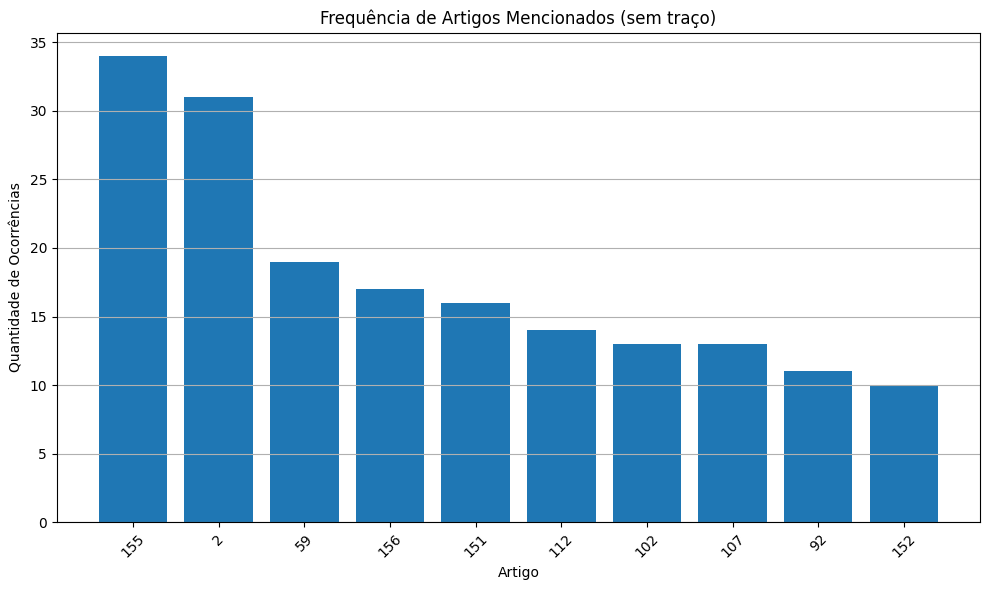

In [133]:
# Converte para DataFrame
df_artigos_sem_traco = contagem_artigos_sem_traco.reset_index().head(10)
df_artigos_sem_traco.columns = ['artigo', 'quantidade']

# Ordena por quantidade decrescente
df_artigos_sem_traco = df_artigos_sem_traco.sort_values(by='quantidade', ascending=False)

# Gera gráfico
plt.figure(figsize=(10, 6))
plt.bar(df_artigos_sem_traco['artigo'], df_artigos_sem_traco['quantidade'])
plt.xlabel('Artigo')
plt.ylabel('Quantidade de Ocorrências')
plt.title('Frequência de Artigos Mencionados (sem traço)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')

plt.show()

In [134]:
# Garante que todos os valores sejam listas
resultado_final['artigos_mencionados'] = resultado_final['artigos_mencionados'].apply(
    lambda x: x if isinstance(x, list) else []
)

# Explode os artigos
artigos_explodido = resultado_final.explode('artigos_mencionados')

# Filtra apenas os que NÃO têm traço
artigos_sem_traco = artigos_explodido[~artigos_explodido['artigos_mencionados'].str.contains('-', na=False)]

# Contagem
contagem_artigos_sem_traco = artigos_sem_traco['artigos_mencionados'].value_counts()

# Filtra os que aparecem 2 ou mais vezes
contagem_filtrada = contagem_artigos_sem_traco[contagem_artigos_sem_traco >= 2]

In [135]:
contagem_filtrada

,count
artigos_mencionados,
155,34
2,31
59,19
156,17
151,16
...,...
167,2
174,2
235,2


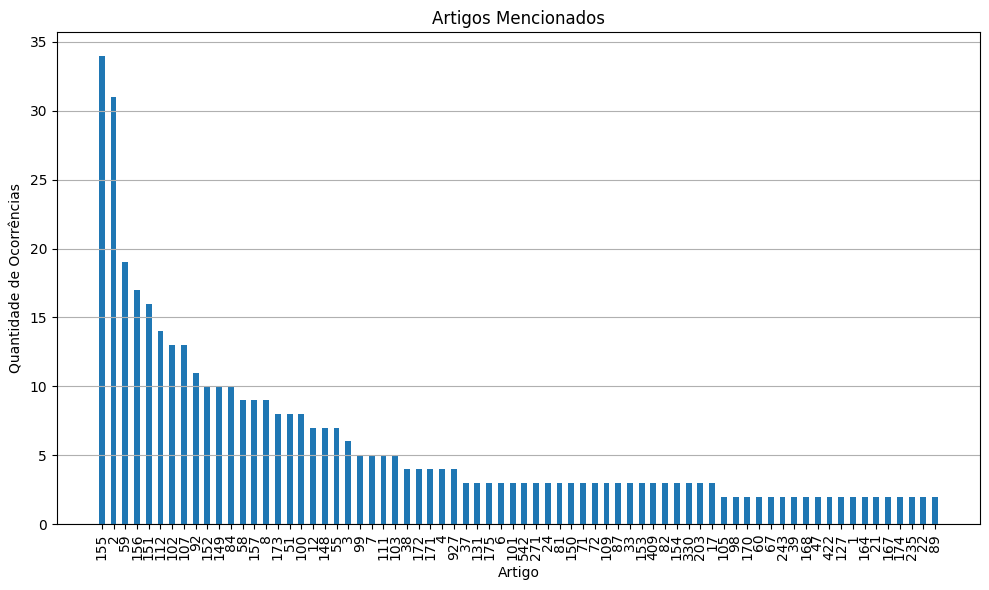

In [136]:
# Converte para DataFrame
df_artigos_sem_traco = contagem_filtrada.reset_index()
df_artigos_sem_traco.columns = ['artigo', 'quantidade']

# Ordena por quantidade decrescente
df_artigos_sem_traco = df_artigos_sem_traco.sort_values(by='quantidade', ascending=False)

# Gera gráfico com rótulos dos artigos na vertical
plt.figure(figsize=(10, 6))
plt.bar(contagem_filtrada.index, contagem_filtrada.values, width=0.5)
plt.xlabel('Artigo')
plt.ylabel('Quantidade de Ocorrências')
plt.title('Artigos Mencionados')
plt.xticks(rotation=90)  # Legenda na vertical
plt.tight_layout()
plt.grid(axis='y')

plt.show()

####Checando artigos com traço

In [137]:
# Filtra apenas os que têm ao menos um artigo com hífen
mascara_com_traco = resultado_final['artigos_mencionados'].apply(lambda artigos: any('-' in a for a in artigos))

# Aplica o filtro
emendas_com_traco = resultado_final[mascara_com_traco]

# Mostra as colunas desejadas
emendas_com_traco[['Emenda', 'artigos_mencionados']]

,Emenda,artigos_mencionados
57,EMENDA 58,"[202-1, 69]"
62,EMENDA 63,"[196-1, 21]"
86,EMENDA 87,"[14, 199-1, 26]"
114,EMENDA 115,"[142, 201-1]"
117,EMENDA 118,"[107, 112-1]"
120,EMENDA 121,"[100, 24, 58, 58-1, 71, 72, 927]"
120,EMENDA 121,"[100, 24, 58, 58-1, 71, 72, 927]"
146,EMENDA 147,"[12, 182, 183, 202-1, 214]"
147,EMENDA 148,"[150, 19, 202-1, 372]"
149,EMENDA 150,"[201-1, 61]"


In [138]:
emendas_com_traco.to_excel('emendas_com_traco.xlsx', index=False)

In [139]:
# Contagem por emenda
contagem = emendas_com_traco['Emenda'].value_counts()
print("\nContagem de emendas com artigos com traço:")
contagem


Contagem de emendas com artigos com traço:


,count
Emenda,
EMENDA 121,2
EMENDA 63,1
EMENDA 58,1
EMENDA 87,1
EMENDA 115,1
EMENDA 118,1
EMENDA 147,1
EMENDA 148,1
EMENDA 150,1


####Checando Classificação e Referencia

In [140]:
resultado_final[resultado_final['Emenda'] == 'EMENDA 104']

,Emenda,Conteudo,antes_da_aspa,depois_da_aspa,classificacao,artigos_mencionados,referencia_legal
103,EMENDA 104,Altere-se o PLP 108/2024 para acrescentar ao a...,Altere-se o PLP 108/2024 para acrescentar ao a...,Art. 7º..........................................,Altere-se,[7],Indefinido
103,EMENDA 104,Altere-se o PLP 108/2024 para acrescentar ao a...,"dar nova redação aos incisos I, VI, VIII, XVII...",Art. 7º..........................................,Outros,[7],Indefinido
103,EMENDA 104,Altere-se o PLP 108/2024 para acrescentar ao a...,"dar nova\nredação aos incisos I, II, XVII, XVI...",Art. 7º..........................................,Outros,[7],Indefinido
103,EMENDA 104,Altere-se o PLP 108/2024 para acrescentar ao a...,suprimir o inciso VI do art.30,Art. 7º..........................................,Suprimir,[7],Indefinido
103,EMENDA 104,Altere-se o PLP 108/2024 para acrescentar ao a...,"e, acrescentar, onde couber, as\ndemais dispos...",Art. 7º..........................................,Outros,[7],Indefinido


In [142]:
resultado_final['referencia_legal'].value_counts()

,count
referencia_legal,
Indefinido,209
Outra lei,127
Sem referência,16


###Gerando Excel

In [143]:
resultado_final

,Emenda,Conteudo,antes_da_aspa,depois_da_aspa,classificacao,artigos_mencionados,referencia_legal
0,EMENDA 1,O § 2º do art. 84 do Projeto de Lei Complement...,O § 2º do art. 84 do Projeto de Lei Complement...,Art. 84. ………………………………………………………………………….\n………………...,Outros,[84],Indefinido
1,EMENDA 2,O art. 85 do Projeto de Lei Complementar nº 10...,O art. 85 do Projeto de Lei Complementar nº 10...,Art. 85. ………………………………………………………………………….\n………………...,Outros,[85],Indefinido
2,EMENDA 3,O art. 87 do Projeto de Lei Complementar nº 10...,O art. 87 do Projeto de Lei Complementar nº 10...,Art. 87. ………………………………………………………………………….\n………………...,Outros,[87],Indefinido
3,EMENDA 4,O art. 92 do Projeto de Lei Complementar nº 10...,O art. 92 do Projeto de Lei Complementar nº 10...,Art. 92. ………………………………………………………………………….\n………………...,Outros,[92],Outra lei
4,EMENDA 5,O § 4º do art. 92 do Projeto de Lei Complement...,O § 4º do art. 92 do Projeto de Lei Complement...,Art. 92. ………………………………………………………………………….\n………………...,Outros,[92],Indefinido
...,...,...,...,...,...,...,...
306,EMENDA 307,"Acrescentem-se arts. 198-1 e 198-2 ao Projeto,...","Acrescentem-se arts. 198-1 e 198-2 ao Projeto,...","Art. 198-1. A Lei Complementar nº 214, de 16 d...",Acrescentem-se,"[107, 198-1, 29]",Outra lei
307,EMENDA 308,"Acrescente-se art. 198-1 ao Projeto, com a seg...","Acrescente-se art. 198-1 ao Projeto, com a seg...",Art. 198-1. Dê-se a seguinte redação ao art. 1...,Acrescente-se,"[103, 198-1, 99]",Outra lei
308,EMENDA 309,"Acrescente-se art. 198-1 ao Projeto, com a seg...","Acrescente-se art. 198-1 ao Projeto, com a seg...","Art. 198-1. A Lei Complementar nº 214, de 16 d...",Acrescente-se,"[100, 198-1, 4, 99]",Outra lei
309,EMENDA 310,Acrescentem-se alíneas “a” e “b” ao inciso I d...,Acrescentem-se alíneas “a” e “b” ao inciso I d...,“Art. 2º ........................................,Acrescentem-se,[2],Outra lei


In [145]:
resultado_final.to_excel('PLP - 108 com artigos.xlsx', index=False)